# Usando deep learning para regressão

Nesse estudo iremos fazer o pipeline completo, desde a aquisição e anotação de dados até o treino de uma rede.
O propósito dessa rede é de rastrar o nariz do usuário.
Nesse jupyter iremos passar pelos seguintes processos:
* Aquisição das imagens
* Anotação da coordenada do nariz para cada imagem do nosso dataset
* Divisão entre dados de treino e validação
* Criação de um BatchGenerator utilizando a lib imgaug
* Criação de uma métrica customizada para nosso modelo
* Criação da arquitetura do nossa rede
* Treinamento
* Validação
* Teste

# Criação do dataset
### 1º Coleta de dados

In [14]:
import os

import cv2
from tqdm import tqdm

DST_FOLDER = "./nose_dataset"

Ao executar a celula abaixo sua webcam será ligada e um frame será salvo a cada 250ms durante a captura de 200 frames, mova seu rosto em toda a area da imagem em diferentes angulos para garantir uma generalização dos seus dados.

In [ ]:

os.makedirs(DST_FOLDER, exist_ok=True)

cap = cv2.VideoCapture(0)

for i in tqdm(range(200)):
    ret, frame = cap.read()
    if not ret:
        raise Exception("Algo deu errado")
    
    cv2.imwrite(os.path.join(DST_FOLDER, f"{i:03d}.jpg"), frame)
    cv2.imshow("debug", frame)
    cv2.waitKey(250)
cv2.destroyAllWindows()
cap.release()

### 2º Anotação dos dados

In [15]:
from imutils import paths

WINDOW_NAME = "annotation"
ANN_FILE = "ann.txt"
images_path = list(paths.list_images(DST_FOLDER))

In [ ]:

class Annotator:
    def __init__(self, window_name, ann_file_path):
        self._window_name = window_name
        self._ann_file_path = ann_file_path
        self._current_fname = ""
        self._done = False
               
        def opencv_callback(event, x, y, *args):

            if event == cv2.EVENT_LBUTTONDOWN:
                with open(self._ann_file_path, "a") as ann_file:
                    ann_file.write(f"{self._current_fname},{x},{y},nose\n")
                self._done = True

            elif event == cv2.EVENT_MOUSEMOVE:
                image_guide_lines = image.copy()
                cv2.line(image_guide_lines, (0, y), (image_guide_lines.shape[1] - 1, y), (0, 255, 0))
                cv2.line(image_guide_lines, (x, 0), (x, image_guide_lines.shape[0] - 1), (0, 255, 0))
                cv2.imshow(self._window_name, image_guide_lines)
        cv2.namedWindow(WINDOW_NAME)
        cv2.setMouseCallback(WINDOW_NAME, opencv_callback)
    
    @property
    def done(self):
        if self._done:
            self._done = False
            return True
        else:
            return False
    
    @property
    def current_fname(self):
        return self._current_fname
    
    @current_fname.setter
    def current_fname(self, value):
        assert isinstance(value, str), "current_fname must be a string."
        self._current_fname = value
        
annotator = Annotator(WINDOW_NAME, ANN_FILE)
for fname in tqdm(images_path):
    image = cv2.imread(fname)
    annotator.current_fname = fname
    cv2.imshow(WINDOW_NAME, image)
    while not annotator.done:
        cv2.waitKey(1)
cv2.destroyAllWindows()

### 3º Dividir treino e validação

In [16]:
import random
basename, ext = os.path.splitext(ANN_FILE)
train_file = f"{basename}_train{ext}"
val_file = f"{basename}_val{ext}"
with open(ANN_FILE) as all_ann, open(train_file, "w") as train_ann, open(val_file, "w") as val_ann:
    lines = [line for line in all_ann]
    random.shuffle(lines)
    for line in lines:
        if random.randint(0, 10) < 8:
            train_ann.write(line)
        else:
            val_ann.write(line)     

# Processamento

### 1º Criação do BatchGenerator

In [17]:
from tensorflow.keras.utils import Sequence
from imgaug import augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = [112, 112]

In [18]:

class BatchGenerator(Sequence):
    def __init__(self, csv_path, size=(224, 224), shuffle=True, norm=None, jitter=True, batch_size=8):
        
        self._shuffle = shuffle
        self._batch_size = batch_size
        self._size = size
        self._norm = norm
        self._jitter = jitter
        with open(csv_path) as ann_file:
            lines = [line for line in ann_file]
        
        self._data = []
        for line in tqdm(lines):
            fname, x, y, label = line.strip().split(",")
            image = cv2.imread(fname)
            x = int(x) / image.shape[1]
            y = int(y) / image.shape[0]
            image = cv2.resize(image, tuple(size))
            info = {"image": image, "x": x, "y": y, "label": label, "fname": fname}
            self._data.append(info)
            
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        self._aug_pipe = iaa.Sequential(
            [

                iaa.Fliplr(0.5),  # horizontally flip 50% of all images
                iaa.Flipud(0.2),  # vertically flip 20% of all images
                sometimes(iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # scale images to 80-120% of their size, per axis
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # translate by -20 to +20 percent
                    rotate=(-50, 50),  # rotate by -45 to +45 degrees
                    shear=(-5, 5),  # shear by -16 to +16 degrees
                )),
                iaa.SomeOf((0, 5),
                           [
                               iaa.OneOf([
                                   iaa.GaussianBlur((0, 3.0)),  # blur images with a sigma between 0 and 3.0
                                   iaa.AverageBlur(k=(2, 7)),
                                   # blur image using local means (kernel sizes between 2 and 7)
                                   iaa.MedianBlur(k=(3, 11)),
                                   # blur image using local medians (kernel sizes between 2 and 7)
                               ]),
                               iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # sharpen images
                               iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),  # emboss images
                               iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
                               # add gaussian noise
                               iaa.OneOf([
                                   iaa.Dropout((0.01, 0.1), per_channel=0.5),  # randomly remove up to 10% of the pixels
                                   iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                               ]),
                               iaa.Invert(0.05, per_channel=True),  # invert color channels
                               iaa.Add((-10, 10), per_channel=0.5),  # change brightness of images
                               iaa.Multiply((0.5, 1.5), per_channel=0.5),  # change brightness of images
                               iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),  # improve or worsen the contrast
                           ],
                           random_order=True
                           )
            ],
            random_order=True
        )
            
    def __len__(self):
        return int(np.ceil(len(self._data) / self._batch_size))
    
    def __getitem__(self, idx):
        l_bound = idx * self._batch_size
        r_bound = (idx + 1) * self._batch_size

        if r_bound > len(self._data):
            r_bound = len(self._data)
            l_bound = r_bound - self._batch_size

        instance_count = 0
        x_batch = np.zeros((r_bound - l_bound, self._size[1], self._size[0], 3))
        y_batch = np.zeros((r_bound - l_bound, 2))

        for instance_count, train_instance in enumerate(self._data[l_bound:r_bound]):
            # augment input image and fix object's position and size
            image = train_instance["image"]
            image, [x, y] = self.aug_image(train_instance)
            if self._norm is not None:
                image = self._norm(image)
            x_batch[instance_count] = image
            y_batch[instance_count, 0] = x
            y_batch[instance_count, 1] = y

        return x_batch, y_batch

    def on_epoch_end(self):
        if self._shuffle:
            np.random.shuffle(self._data)
            
    def aug_image(self, train_instance):
        image = train_instance['image'].copy()

        h = image.shape[0]
        w = image.shape[1]

        x = int(train_instance['x'] * w)
        y = int(train_instance['y'] * h)

        keypoints = KeypointsOnImage([Keypoint(x=x, y=y)], shape=image.shape)

        if self._jitter:
            image, keypoints = self._aug_pipe(image=image, keypoints=keypoints)

        x = keypoints.keypoints[0].x
        y = keypoints.keypoints[0].y
        x = x / w
        y = y / w
        
        return image, [x, y]


In [19]:
_norm = lambda x: x / 255
train_generator = BatchGenerator(train_file, norm=_norm, batch_size=4, size=IMG_SIZE)
val_generator = BatchGenerator(val_file, norm=_norm, batch_size=1, shuffle=False, jitter=False, size=IMG_SIZE)

100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 160.56it/s]


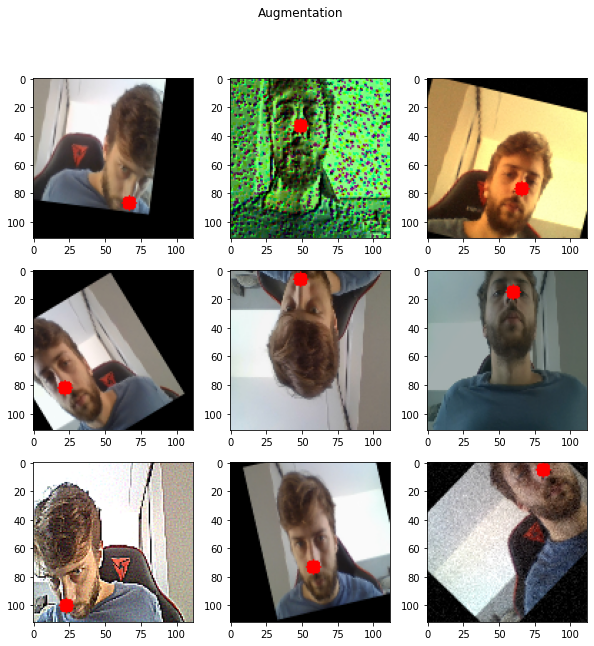

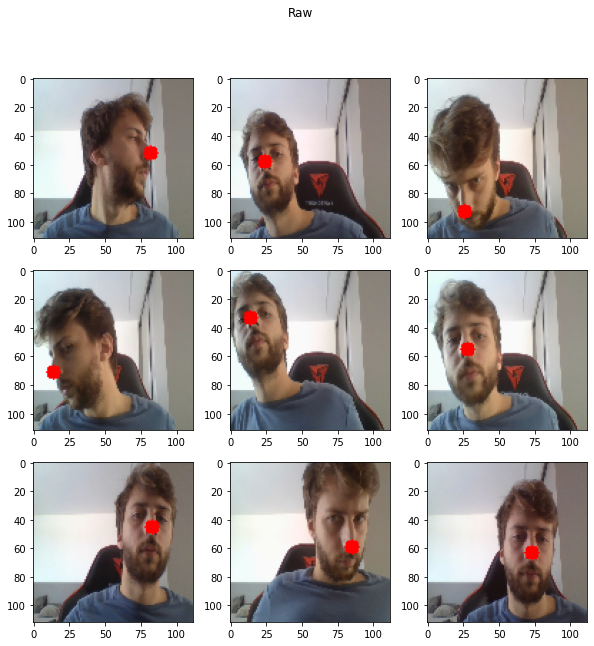

In [21]:

plt.figure(figsize=(10,10))
for i, (batch_x, batch_y) in enumerate(train_generator):
    if i == 9:
        break
    plt.subplot(3,3,i+1)
    debug_img = np.uint8(batch_x[0] * 255)
    debug_coord = batch_y[0]
    debug_coord[0] = debug_coord[0] * debug_img.shape[1]
    debug_coord[1] = debug_coord[1] * debug_img.shape[0]
    debug_coord = debug_coord.astype(np.int32)
    cv2.circle(debug_img, tuple(debug_coord), 5, (0, 0, 255), -1)
    plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
plt.suptitle('Augmentation')
plt.show()

plt.figure(figsize=(10,10))
for i, (batch_x, batch_y) in enumerate(val_generator):
    if i == 9:
        break
    plt.subplot(3,3,i+1)
    debug_img = np.uint8(batch_x[0] * 255)
    debug_coord = batch_y[0]
    debug_coord[0] = debug_coord[0] * debug_img.shape[1]
    debug_coord[1] = debug_coord[1] * debug_img.shape[0]
    debug_coord = debug_coord.astype(np.int32)
    cv2.circle(debug_img, tuple(debug_coord), 5, (0, 0, 255), -1)
    plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
plt.suptitle('Raw')
plt.show()


### 2º Callbakcs

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

MODEL_NAME = "nose_tracker"
best_loss_model_name = f"{MODEL_NAME}_best_loss.h5"
check_point_saver_best_loss = ModelCheckpoint(best_loss_model_name, monitor='val_loss', verbose=1,
                                                    save_best_only=True, save_weights_only=False, mode='auto',
                                                    period=1)

ckp_model_name = f"{MODEL_NAME}_ckp.h5"
check_point_saver = ModelCheckpoint(ckp_model_name, verbose=1, save_best_only=False, save_weights_only=False,
                                    period=10)

tb = TensorBoard(log_dir="./logs", write_graph=True)

### 3º Métrica customizada

In [23]:
import tensorflow as tf

In [24]:
def mean_euclidian_distance(y_true, y_pred):
    med = y_true - y_pred
    med = med**2
    med = med[..., 0] + med[..., 1]
    med = med**0.5
    med = tf.math.reduce_mean(med)
    return med

# Criação e treinamento do modelo
### 1º definição da arquitetura

In [25]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ReLU, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

SCALE = 8
model = Sequential()

model.add(Conv2D(32 // SCALE, (3, 3), padding="same", input_shape=IMG_SIZE + [3]))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(64 // SCALE, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(128 // SCALE, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(64 // SCALE, (1, 1), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(128 // SCALE, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(256 // SCALE, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(128 // SCALE, (1, 1), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(256 // SCALE, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(512 // SCALE, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(256 // SCALE, (1, 1), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(512 // SCALE, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(256 // SCALE, (1, 1), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(512 // SCALE, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(1024//SCALE, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(512//SCALE, (1, 1), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(1024//SCALE, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(512//SCALE, (1, 1), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(1024//SCALE, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(1024//SCALE, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(1024, (1, 1), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(1024//SCALE, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())

model.add(GlobalAveragePooling2D(data_format="channels_last"))

model.add(Dense(2, activation="sigmoid"))

In [26]:
model.compile(loss="MSE", optimizer="sgd", metrics=["MAE", mean_euclidian_distance])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 112, 112, 4)       112       
_________________________________________________________________
batch_normalization_21 (Batc (None, 112, 112, 4)       16        
_________________________________________________________________
re_lu_21 (ReLU)              (None, 112, 112, 4)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 4)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 56, 56, 8)         296       
_________________________________________________________________
batch_normalization_22 (Batc (None, 56, 56, 8)         32        
_________________________________________________________________
re_lu_22 (ReLU)              (None, 56, 56, 8)        

### 2º Treinamento

In [27]:
model.fit(
        train_generator,
        epochs=100,
        steps_per_epoch=1000,
        validation_data=val_generator,
        callbacks=[check_point_saver_best_loss, check_point_saver, tb],
        workers=8,
        max_queue_size=40)

Epoch 1/100
1000/1000 [==============================] - 96s 94ms/step - loss: 0.0652 - MAE: 0.2095 - mean_euclidian_distance: 0.3283 - val_loss: 0.0314 - val_MAE: 0.1460 - val_mean_euclidian_distance: 0.2300

Epoch 00001: val_loss improved from inf to 0.03138, saving model to nose_tracker_best_loss.h5
Epoch 2/100
  27/1000 [..............................] - ETA: 1:26 - loss: 0.0463 - MAE: 0.1766 - mean_euclidian_distance: 0.278 - ETA: 1:26 - loss: 0.0464 - MAE: 0.1767 - mean_euclidian_distance: 0.2785

KeyboardInterrupt: 

### 3º Validação

In [20]:
from tensorflow.keras.models import load_model
model = load_model("nose_tracker_best_loss.h5", compile=False)

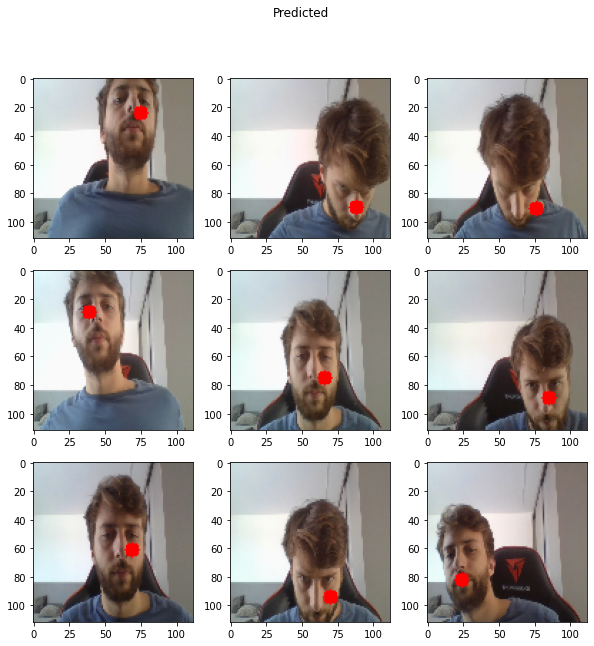

In [21]:
plt.figure(figsize=(10,10))
for i, (batch_x, batch_y) in enumerate(val_generator):
    if i == 9:
        break
    plt.subplot(3,3,i+1)
    pred = model.predict(batch_x[:1])[0]
    debug_img = np.uint8(batch_x[0] * 255)
    debug_coord = pred
    debug_coord[0] = debug_coord[0] * debug_img.shape[1]
    debug_coord[1] = debug_coord[1] * debug_img.shape[0]
    debug_coord = debug_coord.astype(np.int32)
    cv2.circle(debug_img, tuple(debug_coord), 5, (0, 0, 255), -1)
    plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
plt.suptitle('Predicted')
plt.show()


### 4º Teste

In [22]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        raise Exception("Ooops...")
    batch = cv2.resize(frame, tuple(IMG_SIZE))
    batch = _norm(batch)
    batch = batch[np.newaxis]
    x, y = model.predict(batch)[0]
    x = int(x*frame.shape[1])
    y = int(y*frame.shape[0])
    cv2.circle(frame, (x, y), 10, (0, 0, 255), -1)
    cv2.imshow("debug", frame)
    key = cv2.waitKey(1)
    if key == ord("q"):
        break
cv2.destroyAllWindows()
cap.release()

## Exercício
Altere o exemplo para fazer a detecção dos olhos.